# ML -> Supervisionado - Classificação

## Escolha de Features

- Usaremos o modelo RandomForest para escolher as features


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [8]:
DF_model = pd.read_parquet("../arquivos_parquet/DF_to_model.parquet")

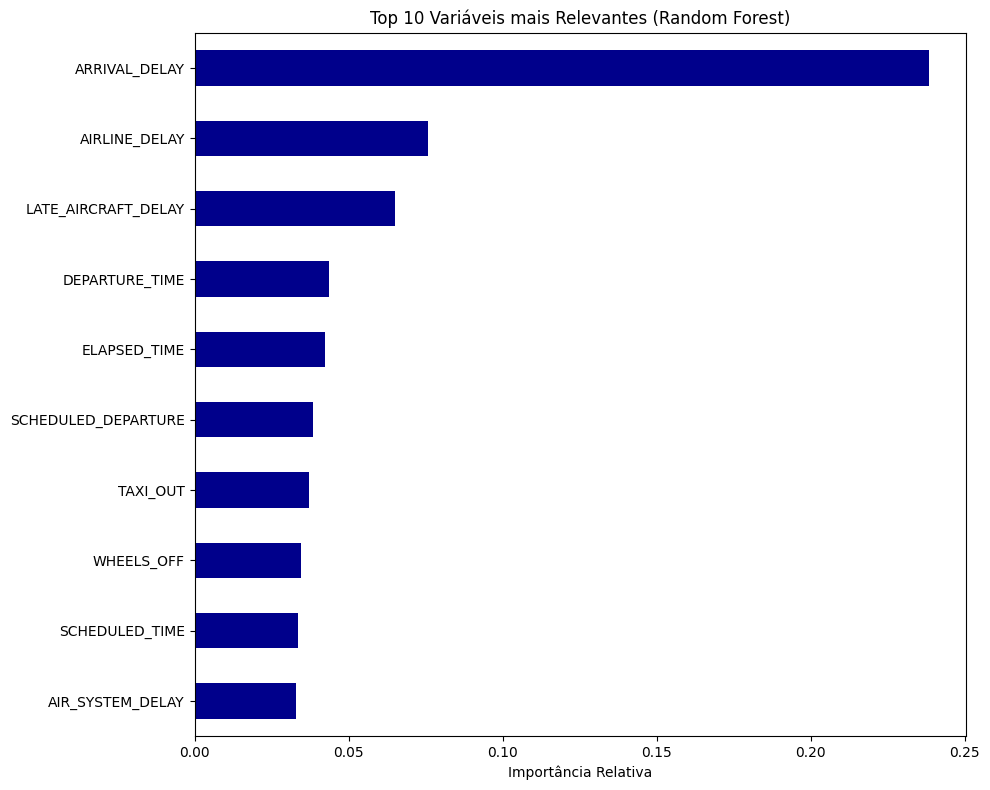

In [10]:
target = "DELAY"

# Removendo DEPARTURE_DELAY para evitar vazamento (leakage), pois ele entrega a resposta
X = DF_model.drop(columns=[target, "DEPARTURE_DELAY"], errors="ignore")
y = DF_model[target]

# 1. Amostragem
X_sample = X.sample(n=1000000, random_state=42)
y_sample = y.loc[X_sample.index]

# 2. Encoding (Lógica mantida, com cópia explícita para evitar avisos do Pandas)
X_encoded = X_sample.copy()
for col in X_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# 3. Treino do Random Forest
# n_jobs=-1 usa todos os núcleos do processador (essencial para 1 milhão de linhas)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_encoded, y_sample)

# 4. Extração de Importâncias
importancias = pd.Series(rf.feature_importances_, index=X_encoded.columns)
importancias_top = importancias.sort_values(ascending=False).head(10)

# 5. Visualização
plt.figure(figsize=(10, 8))
importancias_top.plot(kind="barh", color="darkblue")
plt.title("Top 10 Variáveis mais Relevantes (Random Forest)")
plt.xlabel("Importância Relativa")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Seleção final
features = importancias_top.index.tolist()
val_features = DF_model[features + [target]].copy()

In [12]:
val_features.head(10)

,ARRIVAL_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,DEPARTURE_TIME,ELAPSED_TIME,SCHEDULED_DEPARTURE,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,AIR_SYSTEM_DELAY,DELAY
0,-22.0,0.0,0.0,2354.0,194.0,5,21.0,15.0,205.0,0.0,0
1,-9.0,0.0,0.0,2.0,279.0,10,12.0,14.0,280.0,0.0,0
2,5.0,0.0,0.0,18.0,293.0,20,16.0,34.0,286.0,0.0,0
3,-9.0,0.0,0.0,15.0,281.0,20,15.0,30.0,285.0,0.0,0
4,-21.0,0.0,0.0,24.0,215.0,25,11.0,35.0,235.0,0.0,0
5,8.0,0.0,0.0,20.0,230.0,25,18.0,38.0,217.0,0.0,0
6,-17.0,0.0,0.0,19.0,170.0,25,11.0,30.0,181.0,0.0,0
7,-10.0,0.0,0.0,44.0,249.0,30,13.0,57.0,273.0,0.0,1
8,-13.0,0.0,0.0,19.0,193.0,30,17.0,36.0,195.0,0.0,0
9,-15.0,0.0,0.0,33.0,203.0,30,12.0,45.0,221.0,0.0,1


# Criando o Modelo
